### Filtering SNPS from ipyrad

This notebook will filter SNPs called from ipyrad (and probably stacks and other RADseq pipelines).  The goal of filtering is to reduce individuals with low coverage and missing data and to remove loci that are not biallelic, have too many missing individuals, have very small minor allele frequencies, and lack sufficient sequencing depth.  We should can also remove SNPs that are closely linked to other SNPs, this step should be done last in order to
ensure that the linked SNP we keep passes our other filtering parameters.

**Input files**: an unfiltered snp file in vcf format

**Output files**: a filtered snp file in vcf format

**Modules needed**: vcftools, gzip

#### Set module versions, load modules and load packages

In [1]:
! module load vcftools/0.1.16
! module load gzip/1.12
vcftools = "vcftools"
gzip = "gzip"

import sys
import os
from os import environ
import gzip
import warnings
import pandas as pd
import numpy as np
import scipy as sp
import glob
import re
import random
import matplotlib.pyplot as plt

#### Set values for your directory, set input file name:

In [2]:
mydir = "your/directory/here"

In [3]:
inputfile = "yourvcffile.vcf"

#### Create project dir, move into directory and move vcf file to project directory

If you haven't done the previous ipyrad step of this pipeline, just place your vcf file in the project directory

In [4]:
cd $mydir

/scratch/mw955/mive1


In [5]:
!mkdir filter

mkdir: cannot create directory ‘filter’: File exists


In [6]:
projdir = os.path.join(mydir,"filter")

In [7]:
cp ipyrad/mive_outfiles/mive.vcf filter

In [8]:
cd $projdir

/scratch/mw955/mive1/filter


4. Count number of SNPs in the unfiltered vcf

In [9]:
!cat $inputfile | grep -v '#' | wc -l

213663


## Filter for only biallelic SNPs
Keeping only loci that have exactly two alleles

In [10]:
!module load vcftools/0.1.16

In [11]:
!module load vcftools/0.1.16 && \
vcftools --remove-indels \
--min-alleles 2 \
--max-alleles 2 \
--remove-filtered-all \
--recode \
--recode-INFO-all \
--vcf $inputfile \
--out biallelic


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf mive.vcf
	--recode-INFO-all
	--max-alleles 2
	--min-alleles 2
	--out biallelic
	--recode
	--remove-filtered-all
	--remove-indels

After filtering, kept 192 out of 192 Individuals
Outputting VCF file...
After filtering, kept 189277 out of a possible 213663 Sites
Run Time = 30.00 seconds


## Filter Loci by MAF and missing indviduals
Filtering to keep loci with at least 2% for minor allele frequency and a maximum of 60% missing data.

In [12]:
!module load vcftools/0.1.16 && \
$vcftools \
--max-missing 0.6 \
--maf 0.02 \
--remove-filtered-all \
--recode \
--recode-INFO-all \
--vcf biallelic.recode.vcf \
--out filtered_loci


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf biallelic.recode.vcf
	--recode-INFO-all
	--maf 0.02
	--max-missing 0.6
	--out filtered_loci
	--recode
	--remove-filtered-all

After filtering, kept 192 out of 192 Individuals
Outputting VCF file...
After filtering, kept 18521 out of a possible 189277 Sites
Run Time = 8.00 seconds


## Remove individuals with large amounts of missing data

First we will get a report from vcftools of the number missing SNPs per individual

In [13]:
!module load vcftools/0.1.16 && \
vcftools \
--vcf filtered_loci.recode.vcf \
--missing-indv \
--recode \
--recode-INFO-all \
--out filtered_loci




Error: Only one output function may be called.



**Examine the report to come up with a cut off for missing data:**

In [15]:
imiss_df = pd.read_csv("filtered_loci.imiss", sep="\t")
imiss_df.index = imiss_df.INDV

In [16]:
imiss_df.head()

,INDV,N_DATA,N_GENOTYPES_FILTERED,N_MISS,F_MISS
INDV,,,,,
100AZ5,100AZ5,18521,0,1254,0.067707
101AZ6,101AZ6,18521,0,1262,0.068139
102AZ7,102AZ7,18521,0,8025,0.433292
103AZ8,103AZ8,18521,0,2219,0.119810
104AZ9,104AZ9,18521,0,2693,0.145403


In [17]:
imiss_df.F_MISS.describe()

count    192.000000
mean       0.194197
std        0.187218
min        0.036391
25%        0.070353
50%        0.112251
75%        0.265253
max        0.991091
Name: F_MISS, dtype: float64

array([[<Axes: title={'center': 'F_MISS'}>]], dtype=object)

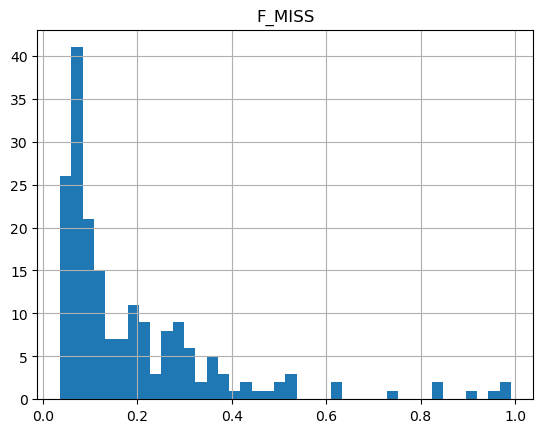

In [18]:
imiss_df.hist(column= "F_MISS", bins= 40)

**Based on the above figure I'm thinking we remove individuals missing more than 50% of the data.  Lets see how many individuals that is and which ones they are:**

In [19]:
len(imiss_df),len(imiss_df[imiss_df.F_MISS >= .4]),len(imiss_df[imiss_df.F_MISS >= .5]), len(imiss_df[imiss_df.F_MISS >= .6])


(192, 19, 13, 9)

In [20]:
bad_indv40 = imiss_df.INDV[imiss_df.F_MISS >= .4]
bad_indv50 = imiss_df.INDV[imiss_df.F_MISS >= .5]
bad_indv60 = imiss_df.INDV[imiss_df.F_MISS >= .6]

In [21]:
print(bad_indv40)

INDV
102AZ7      102AZ7
110ASU4    110ASU4
112ASU6    112ASU6
113ASU7    113ASU7
121SC        121SC
126SC        126SC
130MG        130MG
138DC        138DC
146VP        146VP
153AC        153AC
161GC        161GC
171MC        171MC
177MC        177MC
184FC        184FC
185FC        185FC
40DS          40DS
59UF          59UF
68BL          68BL
96AZ1        96AZ1
Name: INDV, dtype: object


In [22]:
print(bad_indv50)

INDV
112ASU6    112ASU6
113ASU7    113ASU7
121SC        121SC
130MG        130MG
138DC        138DC
146VP        146VP
153AC        153AC
161GC        161GC
177MC        177MC
184FC        184FC
185FC        185FC
68BL          68BL
96AZ1        96AZ1
Name: INDV, dtype: object


In [23]:
print(bad_indv60)

INDV
113ASU7    113ASU7
130MG        130MG
146VP        146VP
153AC        153AC
161GC        161GC
177MC        177MC
185FC        185FC
68BL          68BL
96AZ1        96AZ1
Name: INDV, dtype: object


**Ok, I think I'm going to remove individuals missing 50% of their data or more, this means I'm removing 13 individuals and retaining 179**

In [24]:
badindv = imiss_df.INDV[imiss_df.F_MISS >= .5]

In [25]:
badindv.to_csv("badindv.txt", header=False, index=False, sep="\t")

In [ ]:
!cat badindv.txt

**removing individuals with greater than 50% missing loci:**

In [27]:
!module load vcftools/0.1.16 && \
vcftools \
--vcf filtered_loci.recode.vcf \
--remove badindv.txt \
--recode \
--recode-INFO-all \
--out filtered_indv


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf filtered_loci.recode.vcf
	--remove badindv.txt
	--recode-INFO-all
	--out filtered_indv
	--recode

Excluding individuals in 'exclude' list
After filtering, kept 179 out of 192 Individuals
Outputting VCF file...
After filtering, kept 18521 out of a possible 18521 Sites
Run Time = 7.00 seconds


## Thin SNPs so that there is only one SNP per RADtag

**From running fastqc, our RADtags are 122bp, so I'm going to use that as my thinning distance**

In [29]:
!module load vcftools/0.1.16 && \
vcftools \
--vcf filtered_indv.recode.vcf \
--thin 122 \
--recode \
--recode-INFO-all \
--out thinned


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf filtered_indv.recode.vcf
	--recode-INFO-all
	--thin 122
	--out thinned
	--recode

After filtering, kept 179 out of 179 Individuals
Outputting VCF file...
After filtering, kept 5128 out of a possible 18521 Sites
Run Time = 5.00 seconds


## Final data set is **5128 loci, 179 individuals**

## Output 012
There are other output files availble in vcftools including plink and BEAGLE

In [1]:
!module load vcftools && vcftools \
--vcf thinned.recode.vcf \
--out snps \
--012


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf thinned.recode.vcf
	--012
	--out snps

stat error: No such file or directory
Error: Can't determine file type of thinned.recode.vcf


## Next step:  PCA

**make PCA folder and put plink in it

In [2]:
cd ..

/home


In [3]:
mkdir pca

mkdir: cannot create directory ‘pca’: Permission denied


In [4]:
cp filter/snps.* pca/

cp: cannot stat 'filter/snps.*': No such file or directory
